## **CartPole Swing-Up Problem**

### **Overview**
The CartPole swing-up problem is a classical control problem where a cart, moving on a 1D track, is connected to a pendulum (a pole), and the objective is to swing the pole from an initial position (usually downwards) to an upright position (balancing vertically) by applying horizontal forces to the cart. The challenge here is not just balancing the pendulum but swinging it up from an initial state of rest.

The dynamics of this system are nonlinear, meaning the equations of motion involve terms like products of velocities and trigonometric functions. This makes it a more complex control problem than simpler linear systems. Additionally, constraints like the control force limits and track boundaries make the problem more realistic and difficult to solve.

### **Objective**
The goal is to compute an optimal trajectory that moves the cart and swings the pendulum up to the desired position while minimizing control effort (force) and adhering to system constraints such as force limits, position limits, and realistic system dynamics.

---

## **Modeling the CartPole System**

The cart-pole system consists of two primary elements:

1. **Cart**: A mass \(m_c\) that moves horizontally on a frictionless track.
2. **Pole**: A pendulum of length \(l\) and mass \(m_p\) that rotates freely about the pivot point (attached to the cart).

### **State Variables**
The state of the system can be represented by four variables:

- \($x$\): Horizontal position of the cart.
- \($\theta$\): Angular position of the pendulum (relative to the vertical).
- \($\dot{x}$\): Horizontal velocity of the cart.
- \($\dot{\theta}$\): Angular velocity of the pendulum.

### **Equations of Motion**
The system's motion is governed by Newton's second law for both the linear motion of the cart and the rotational motion of the pendulum. The equations can be derived using the Lagrangian mechanics and result in a set of coupled nonlinear differential equations.

Let the control input \(u(t)\) represent the horizontal force applied to the cart. The system dynamics can be expressed as:

\[
$m_c \ddot{x} + m_p l \ddot{\theta} \cos(\theta) - m_p l \dot{\theta}^2 \sin(\theta) = u$
\]
\[
$m_p l^2 \ddot{\theta} + m_p g l \sin(\theta) = -m_p l \ddot{x} \cos(\theta)$
\]

Where:
- \(g\) is the gravitational acceleration.

### **Constraints**
- **Control Force Limits**: \($u_{min} \leq u \leq u_{max}$\)
- **Track Limits**: The cart can move within specific limits \($x_{min} \leq x \leq x_{max}$\).

---

## **Method Used: Direct Collocation for Optimal Control**

Direct collocation is a numerical optimization technique used for solving optimal control problems. Instead of solving the system's differential equations directly, the problem is converted into a nonlinear programming problem by discretizing the control and state trajectories over time.

### **Steps in Direct Collocation:**

1. **Discretization**: 
   The continuous time horizon \(T\) is divided into \(n\) time steps, and the state and control variables are represented at discrete points in time. This transforms the problem into one with a finite number of variables.

2. **Objective Function**: 
   The optimization seeks to minimize an objective function, typically the total control effort over the entire trajectory. In this case, it is formulated as:
   
   \[
   $J = \int_0^T u(t)^2 \, dt$
   \]
   
   In practice, this integral is approximated by summing up the control effort at discrete time points.

3. **Constraints**:
   - System dynamics (discretized using collocation points, enforcing the equations of motion).
   - Boundary conditions (e.g., initial and final states).
   - Control and state limits (such as bounds on \(u\), \(x\), etc.).

4. **Nonlinear Optimization**:
   After discretizing the problem, it is solved using nonlinear optimization solvers (e.g., `scipy.optimize`), which find the state and control trajectories that minimize the objective while satisfying the constraints.

---

## **Conclusion**
This implementation of the CartPole swing-up problem uses the **Direct Collocation** method for optimal control, discretizing the time horizon and solving a nonlinear programming problem. The method efficiently computes the optimal trajectory for the system, satisfying all constraints and minimizing the control effort.

In [107]:
import matplotlib.pyplot as plt # data plotting
import numpy as np # linear algebra
from dataclasses import *
import scipy.optimize as optimize
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
from EnforceTyping import enforce_method_typing, EnforceClassTyping
sys.path.insert(1, '/Users/niyi/Documents/GitHub/Optimal-Control/Systems')
from ParticlesandFields import Field, ClassicalParticle
sys.path.insert(2, '/Users/niyi/Documents/GitHub/Optimal-Control/Optimal Control Methods/Planning Methods')
from DirectCollocation import  DirectCollocation

In [108]:
@dataclass
class CartPole(EnforceClassTyping, DirectCollocation):
    cart_mass: float # (kg)
    pendulum_mass: float # (kg)
    pendulum_length: float # (m)
    gravitational_acceleration: float # (m/s^2)
    u_min: float # minimum control force (N)
    u_max : float # maximum control force (N)
    track_min: float
    track_max: float
    
    def __post_init__(self):
      self.collocation_points = np.linspace(0, self.final_time, self.n_time_steps)
      self.time_increment= self.collocation_points[1] - self.collocation_points[0]  
      self.optimal_trajectory= self.initial_guess
      self.bounds = [(self.track_min, self.track_max)] * self.n_time_steps+ [(None, None)] * (3*self.n_time_steps) + [(self.u_min, self.u_max)] * self.n_time_steps

    def objective(self, flattened_trajectory: np.ndarray) -> float:
      _, _, _, _, control = flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      # effort= 0.0
      # for t in range(self.n_time_steps-1):
      #   effort += (self.time_increment/2)* (control[t]**2+ control[t+1]**2)
      return np.sum(control**2)
  
    def state_dynamics(self, state: np.ndarray, time: float, control: np.ndarray):
      position, angle, velocity, angular_velocity = state
      acceleration = ((self.pendulum_length*self.pendulum_mass*np.sin(angle)* angular_velocity**2)+ control+ (self.pendulum_mass*self.gravitational_acceleration*np.cos(angle)*np.sin(angle))) / self.cart_mass+ self.pendulum_mass*(1-np.cos(angle)**2)
      angular_acceleration = -((self.pendulum_length*self.pendulum_mass*np.cos(angle)*np.sin(angle)* angular_velocity**2)+ control*np.cos(angle)+ ((self.pendulum_mass+self.cart_mass)*self.gravitational_acceleration*np.sin(angle))) / (self.pendulum_length*self.cart_mass+  self.pendulum_length*self.pendulum_mass*(1-np.cos(angle)**2))
      return np.array([velocity, angular_velocity, acceleration, angular_acceleration])
    
    def dynamics_constraint(self, flattened_trajectory: np.ndarray):
      position, angle, velocity, angular_velocity, control = flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      state_vectors= np.vstack((position, angle, velocity, angular_velocity)).transpose()
      control_vectors= control.transpose()
      ceq = []

      for k in range(self.n_time_steps-1):
        time= k* self.time_increment
        state_derivative = self.state_dynamics(state=state_vectors[k], time= time, control=control_vectors[k])
        next_state_derivative = self.state_dynamics(state=state_vectors[k+1], time= time, control=control_vectors[k+1])
        numerical_state_change= (state_vectors[k+1] - state_vectors[k])
        analytical_state_change= (self.time_increment * (state_derivative + next_state_derivative))/2
        ceq.append(numerical_state_change - analytical_state_change)
      return np.array(ceq).flatten()
    
    def boundary_constraints(self, flattened_trajectory: np.ndarray):
      position_x, position_y, velocity_x, velocity_y, _= flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      final_state_vector= np.vstack((position_x, position_y, velocity_x, velocity_y)).transpose()[-1]
      initial_state_vetor= np.vstack((position_x, position_y, velocity_x, velocity_y)).transpose()[0]
      trajectory_boundary= np.concatenate((initial_state_vetor, final_state_vector), axis=None)
      boundary_constraint= np.concatenate((self.initial_state, self.final_state), axis=None)
      return trajectory_boundary-boundary_constraint
    
    def solve(self):
        solution = optimize.minimize(self.objective, 
                                     self.initial_guess, 
                                     method='SLSQP', 
                                     bounds=self.bounds,
                                     constraints=({'type': 'eq', 'fun': self.dynamics_constraint}, 
                                                  {'type': 'eq', 'fun': self.boundary_constraints}), 
                                     tol= 1e-9) 
        self.optimal_trajectory= solution.x
    
    def plot_trajectory(self, flattened_trajectory: np.ndarray= None):
      if flattened_trajectory is None:
        flattened_trajectory= self.optimal_trajectory
      position, angle, velocity, angular_velocity, control = flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      state_vectors= np.vstack((position, angle, velocity, angular_velocity)).transpose()
      control_vectors= control.transpose()

      plt.figure(figsize=(12, 10))

      plt.subplot(3, 2, 1)
      plt.plot(self.collocation_points, state_vectors[:, 0])
      plt.title('Cart Position')
      plt.xlabel('Time (s)')
      plt.ylabel('Position (m)')

      plt.subplot(3, 2, 3)
      plt.plot(self.collocation_points, state_vectors[:, 1])
      plt.title('Pendulum Angle')
      plt.xlabel('Time (s)')
      plt.ylabel('Angle (rad)')

      plt.subplot(3, 2, 2)
      plt.plot(self.collocation_points, state_vectors[:, 2])
      plt.title('Cart Velocity')
      plt.xlabel('Time (s)')
      plt.ylabel('Velocity (m/s)')

      plt.subplot(3, 2, 4)
      plt.plot(self.collocation_points, state_vectors[:, 3])
      plt.title('Pendulum Angular Velocity')
      plt.xlabel('Time (s)')
      plt.ylabel('Angular Velocity (rad/s)')

      plt.subplot(3, 2, 5)
      plt.plot(self.collocation_points, control_vectors)
      plt.title('Control Input')
      plt.xlabel('Time (s)')
      plt.ylabel('Force (N)')
      plt.axhline(y=self.u_max, color='r', linestyle='--', label='Max Force')
      plt.axhline(y=self.u_min, color='r', linestyle='--', label='Min Force')
      plt.legend()

      plt.tight_layout()
      plt.show()


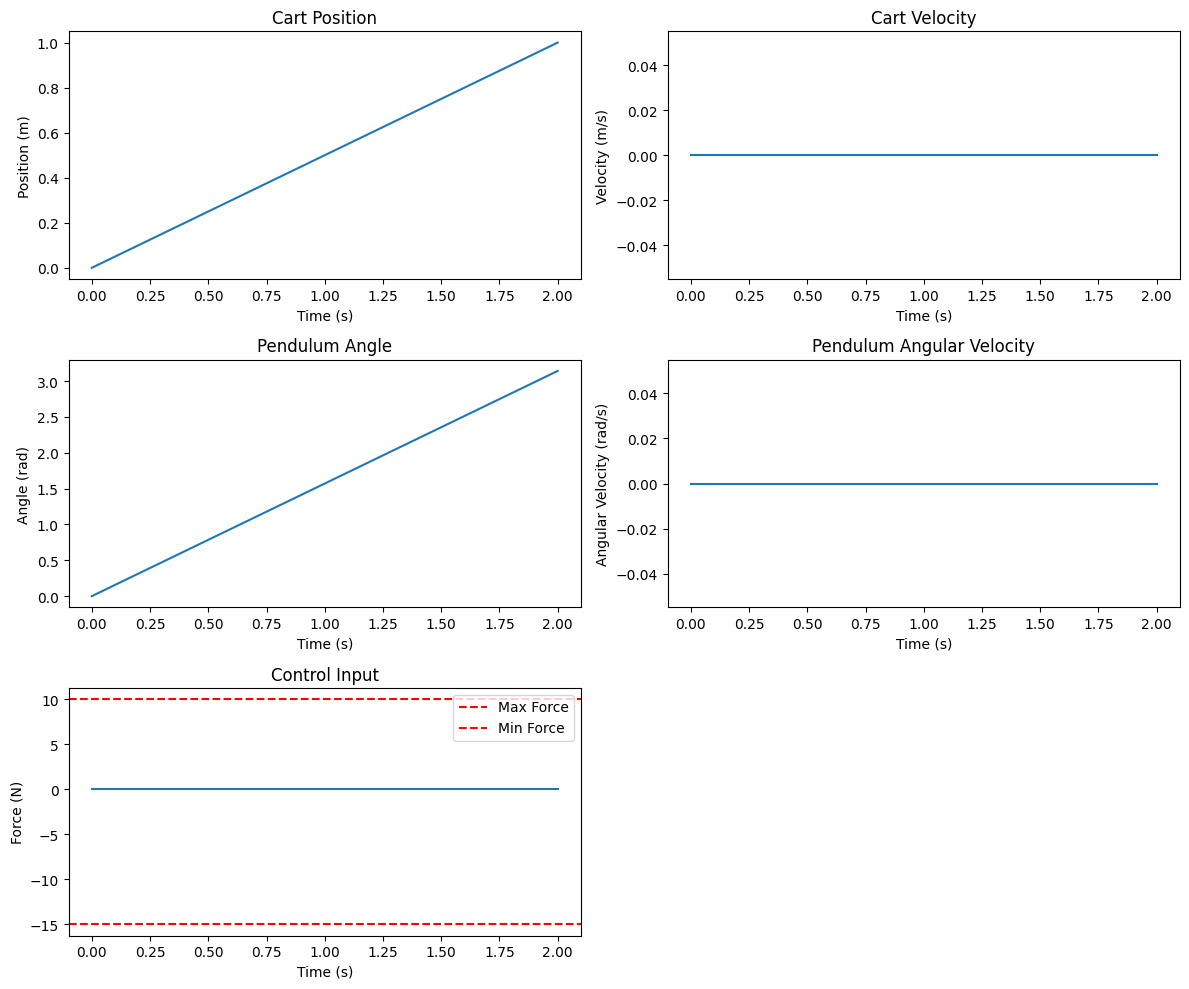

0.0

In [109]:
cart_mass = 1.0  # (kg)
pendulum_mass = 0.3  # (kg)
pendulum_length = 0.5    # (m)
gravitational_acceleration = 9.81   # (m/s^2)
n_time_steps = 100    # number of time steps
final_time = 2.0  # final time (s)
u_min = -15.0  # minimum control force (N)
u_max = 10.0   # maximum control force (N)
track_min= -5.0 # (m)
track_max = 5.0 # (m)
final_state= np.array([1.0, np.pi, 0.0, 0.0]) #[x, θ, v_x, v_θ]
initial_state= np.array([0.0, 0.0, 0.0, 0.0]) #[x, θ, v_x, v_θ]
control_dims= (1,)

initial_guess= np.zeros(n_time_steps*(initial_state.size+ np.prod(control_dims)))
initial_guess[:n_time_steps] = np.linspace(initial_state[0], final_state[0], n_time_steps)  # x Initial Guess
initial_guess[n_time_steps:2*n_time_steps] = np.linspace(initial_state[1], final_state[1], n_time_steps)  # θ Initial Guess
initial_guess[2*n_time_steps:3*n_time_steps] = np.linspace(initial_state[2], final_state[2], n_time_steps)  # x Velocity Initial Guess
initial_guess[3*n_time_steps:4*n_time_steps] = np.linspace(initial_state[3], final_state[3], n_time_steps)  # θ Velocity Initial Guess

swing_up_cart_pole= CartPole(n_time_steps,
                             final_time,
                             initial_state,
                             final_state,
                             control_dims,
                             initial_guess,
                             cart_mass,
                             pendulum_mass,
                             pendulum_length,
                             gravitational_acceleration,
                             u_min, 
                             u_max,
                             track_min,
                             track_max)
swing_up_cart_pole.plot_trajectory(initial_guess)
swing_up_cart_pole.objective(initial_guess)

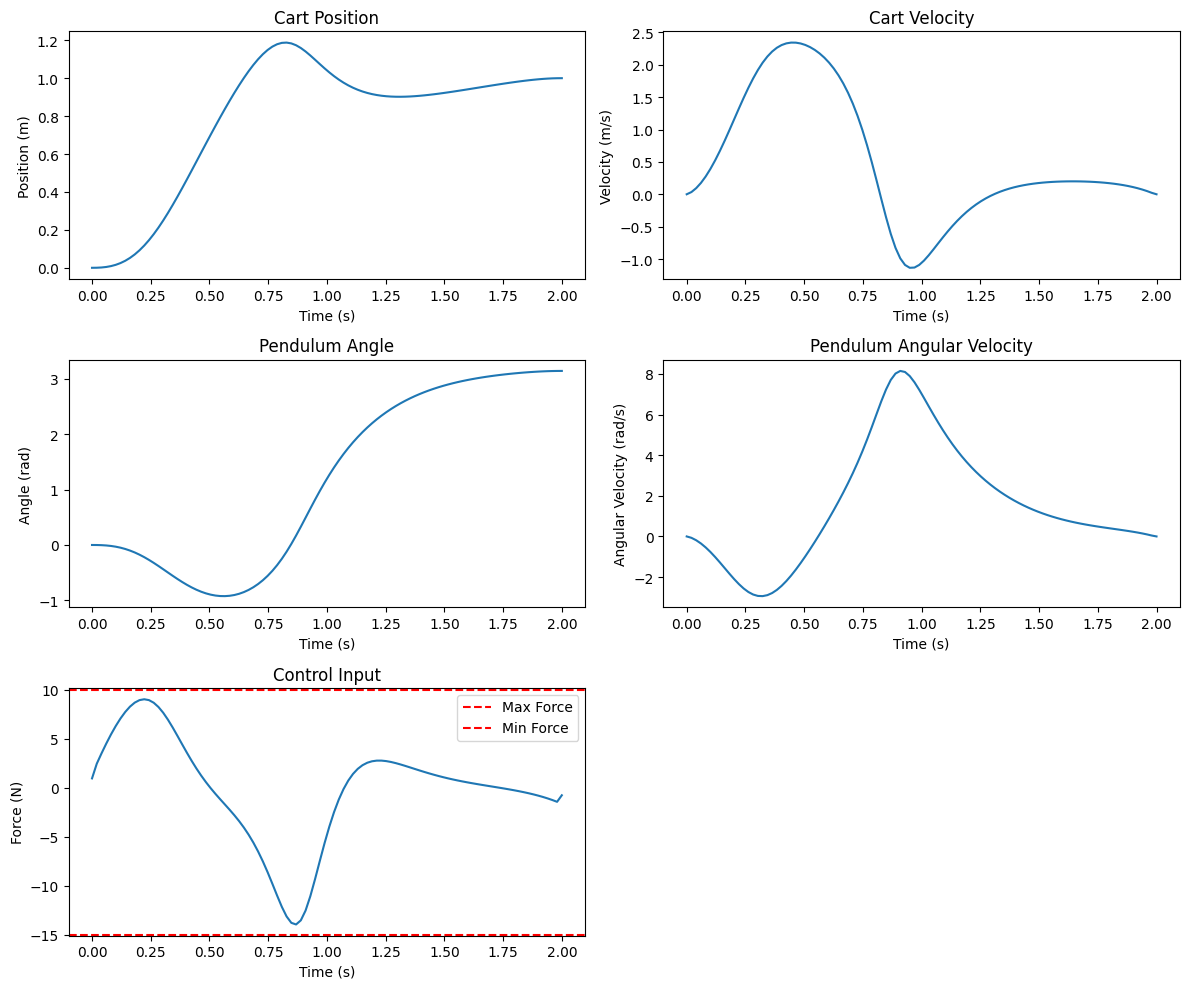

2925.452861266331

In [110]:
swing_up_cart_pole.solve()
swing_up_cart_pole.plot_trajectory()
swing_up_cart_pole.objective(swing_up_cart_pole.optimal_trajectory)